In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch
!pip install -q torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-m_y5498b
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-m_y5498b
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit e7cbea0bbd546167b9d1757b2cfeca3fbe26a33e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 32.1 MB/s eta 0:00:00
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.3.2-py

https://github.com/qubvel/segmentation_models.pytorch

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torchsummary import summary

import segmentation_models_pytorch as smp

from PIL import Image
import albumentations, cv2, time, os
from tqdm.notebook import tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Create Dataset**

Aerial Semantic Segmentation Drone Dataset from https://www.kaggle.com/datasets/bulentsiyah/semantic-drone-dataset - 23 different classes

In [ ]:
!unzip /content/drive/MyDrive/segmentation_ml/segmentation_with_transformer/dataset.zip

Archive:  /content/drive/MyDrive/segmentation_ml/segmentation_with_transformer/dataset.zip
  inflating: semantic_drone_dataset/label_images_semantic/000.png  
  inflating: semantic_drone_dataset/label_images_semantic/001.png  
  inflating: semantic_drone_dataset/label_images_semantic/002.png  
  inflating: semantic_drone_dataset/label_images_semantic/003.png  
  inflating: semantic_drone_dataset/label_images_semantic/004.png  
  inflating: semantic_drone_dataset/label_images_semantic/005.png  
  inflating: semantic_drone_dataset/label_images_semantic/006.png  
  inflating: semantic_drone_dataset/label_images_semantic/008.png  
  inflating: semantic_drone_dataset/label_images_semantic/011.png  
  inflating: semantic_drone_dataset/label_images_semantic/013.png  
  inflating: semantic_drone_dataset/label_images_semantic/014.png  
  inflating: semantic_drone_dataset/label_images_semantic/015.png  
  inflating: semantic_drone_dataset/label_images_semantic/016.png  
  inflating: semantic_dro

In [ ]:
classes = pd.read_csv('/content/class_dict_seg.csv')

In [ ]:
classes

,name,r,g,b
0,unlabeled,0,0,0
1,paved-area,128,64,128
2,dirt,130,76,0
3,grass,0,102,0
4,gravel,112,103,87
5,water,28,42,168
6,rocks,48,41,30
7,pool,0,50,89
8,vegetation,107,142,35
9,roof,70,70,70


In [ ]:
classes_names = classes.name.values.tolist()
print(classes_names)
len(classes_names)

['unlabeled', 'paved-area', 'dirt', 'grass', 'gravel', 'water', 'rocks', 'pool', 'vegetation', 'roof', 'wall', 'window', 'door', 'fence', 'fence-pole', 'person', 'dog', 'car', 'bicycle', 'tree', 'bald-tree', 'ar-marker', 'obstacle', 'conflicting']


24

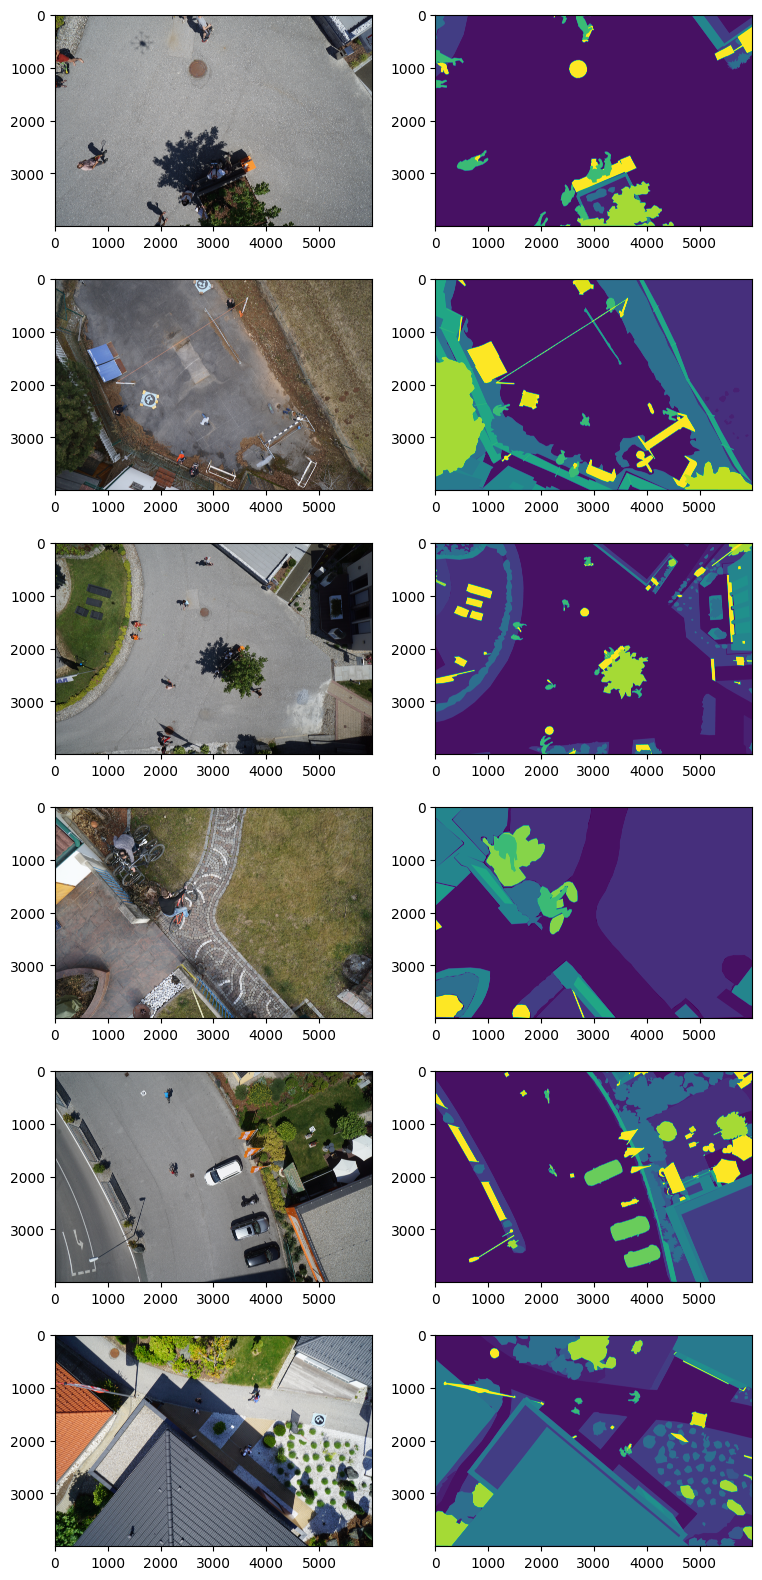

In [ ]:
plt.figure(figsize = (9, 20))
for n in range(6):
    image = np.array(Image.open(f'/content/semantic_drone_dataset/original_images/00{n}.jpg'))
    label = np.array(Image.open(f'/content/semantic_drone_dataset/label_images_semantic/00{n}.png'))
    plt.subplot(6, 2, 2 * n + 1)
    plt.imshow(image)
    plt.subplot(6, 2, 2 * n + 2)
    plt.imshow(label)

In [ ]:
image.shape, label.shape, image.min(), image.max(), label.min(), label.max()

((4000, 6000, 3), (4000, 6000), 0, 255, 0, 22)

In [ ]:
nunber_of_classes = 23 
def create_dataset_df():
  original_images = [filenames for _, _, filenames in os.walk('/content/semantic_drone_dataset/original_images')][0]
  original_images.sort()
  label_images_semantic = [filenames for _, _, filenames in os.walk('/content/semantic_drone_dataset/label_images_semantic')][0]
  label_images_semantic.sort()
  return pd.DataFrame({'label_images_semantic': label_images_semantic}, index=original_images)
dataset = create_dataset_df()
print('Total images pairs: ', len(dataset))

Total images pairs:  400


In [ ]:
x_train_and_val, x_test = train_test_split(dataset, test_size=0.1, random_state=13)
x_train, x_val = train_test_split(x_train_and_val, test_size=0.2, random_state=13)
print('Train size -', len(x_train), 'Val size -', len(x_val), 'Test size -', len(x_test))

Train size - 288 Val size - 72 Test size - 40


In [ ]:
class ImageSegmentationDataset(Dataset):
    def __init__(self, original_images, label_images_semantic, sample, mean, std, 
                 transform=None, patch=False):
        self.original_images = original_images
        self.label_images_semantic = label_images_semantic
        self.sample = sample
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.sample)
    
    def __getitem__(self, idx):
        image = cv2.cvtColor(cv2.imread(self.original_images + 
                                      self.sample.index.values[idx]), cv2.COLOR_BGR2RGB)
        label = cv2.imread(self.label_images_semantic + self.sample.label_images_semantic.values[idx], cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=image, mask=label)
            image, label = Image.fromarray(aug['image']), aug['mask']
        
        if self.transform is None:
            image = Image.fromarray(image)
        
        transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                            torchvision.transforms.Normalize(self.mean, self.std)])
        image, label = transform(image), torch.from_numpy(label).long()
        
        if self.patches:
            image, label = self.tiles(image, label)
        return image, label
    
    def tiles(self, image, label):

        image_patches = image.unfold(1, 512, 512).unfold(2, 768, 768) 
        image_patches  = image_patches.contiguous().view(3,-1, 512, 768) 
        image_patches = image_patches.permute(1,0,2,3)
        
        label_patches = label.unfold(0, 512, 512).unfold(1, 768, 768)
        label_patches = label_patches.contiguous().view(-1, 512, 768)
        
        return image_patches, label_patches

In [ ]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = albumentations.Compose([albumentations.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), 
                                  albumentations.HorizontalFlip(), albumentations.VerticalFlip(), 
                                  albumentations.GridDistortion(p=0.2), albumentations.RandomBrightnessContrast((0,0.5),(0,0.5)),
                                  albumentations.GaussNoise()])

t_val = albumentations.Compose([albumentations.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), 
                                albumentations.HorizontalFlip(),
                                albumentations.GridDistortion(p=0.2)])

train_set = ImageSegmentationDataset('/content/semantic_drone_dataset/original_images/', 
                         '/content/semantic_drone_dataset/label_images_semantic/', x_train, mean, std, t_train, patch=False)
val_set = ImageSegmentationDataset('/content/semantic_drone_dataset/original_images/', 
                         '/content/semantic_drone_dataset/label_images_semantic/', x_val, mean, std, t_val, patch=False)

batch_size= 3 

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)               

## **Models From Pytorch**

In [ ]:
models = {
    #'PAN': smp.PAN('mobilenet_v2', encoder_weights='imagenet', classes=23, activation=None),
    'DeepLabV3': smp.DeepLabV3('mobilenet_v2', encoder_weights='imagenet', classes=23, activation=None),
    'DeepLabV3Plus': smp.DeepLabV3Plus('mobilenet_v2', encoder_weights='imagenet', classes=23, activation=None)
    }

In [ ]:
def pixel_accuracy(output, label):
    with torch.no_grad():
        output = torch.argmax(torch.nn.functional.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, label).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [ ]:
def mIoU(predicted_label, label, smooth=1e-10, number_of_classes=23):
    with torch.no_grad():
        predicted_label = torch.nn.functional.softmax(predicted_label, dim=1)
        predicted_label = torch.argmax(predicted_label, dim=1).contiguous().view(-1)
        label = label.contiguous().view(-1)
        iou_per_class = list()
        for class_number in range(0, number_of_classes):  # loop per pixel class
            predicted_class = predicted_label == class_number
            true_label = label == class_number

            if true_label.long().sum().item() == 0:  # no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(predicted_class, true_label).sum().float().item()
                union = torch.logical_or(predicted_class, true_label).sum().float().item()
                iou_per_class.append((intersect + smooth) / (union + smooth))
        return np.nanmean(iou_per_class)

In [ ]:
def get_learning_rate(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses, test_losses, val_iou, val_acc, train_iou, train_acc, learning_rates = list(), list(), list(), list(), \
        list(), list(), list()
    min_loss, decrease, not_improve = np.inf, 1, 0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        running_loss, iou_score, accuracy = 0, 0, 0
        model.train()
        for _, data in enumerate(tqdm(train_loader)):
            image_tiles, label_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()
                image_tiles, label_tiles = image_tiles.view(-1, c, h, w), label_tiles.view(-1, h, w)

            image, label = image_tiles.to(device), label_tiles.to(device)
            output = model(image)
            loss = criterion(output, label)
            iou_score += mIoU(output, label)
            accuracy += pixel_accuracy(output, label)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            learning_rates.append(get_learning_rate(optimizer))
            scheduler.step()
            running_loss += loss.item()
        else:
            model.eval()
            test_loss, test_accuracy, val_iou_score =0, 0, 0
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    image_tiles, label_tiles = data
                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()
                        image_tiles, label_tiles = image_tiles.view(-1, c, h, w), label_tiles.view(-1, h, w)

                    image, label = image_tiles.to(device), label_tiles.to(device);
                    output = model(image)
                    val_iou_score += mIoU(output, label)
                    test_accuracy += pixel_accuracy(output, label)
                    loss = criterion(output, label)
                    test_loss += loss.item()

            # calculatio mean for each batch
            train_losses.append(running_loss / len(train_loader))
            test_losses.append(test_loss / len(val_loader))

            if min_loss > (test_loss / len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss / len(val_loader))))
                min_loss = (test_loss / len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')

            if (test_loss / len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss / len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break

            val_iou.append(val_iou_score / len(val_loader))
            train_iou.append(iou_score / len(train_loader))
            train_acc.append(accuracy / len(train_loader))
            val_acc.append(test_accuracy / len(val_loader))
            print("Epoch:{}/{}..".format(e + 1, epochs), "Train Loss: {:.3f}..".format(running_loss / len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss / len(val_loader)), "Train mIoU:{:.3f}..".format(iou_score / len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score / len(val_loader)), "Train Acc:{:.3f}..".format(accuracy / len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy / len(val_loader)))
    history = {'train_loss': train_losses, 'val_loss': test_losses, 'train_miou': train_iou, 'val_miou': val_iou,
               'train_acc': train_acc, 'val_acc': val_acc, 'lrs': learning_rates}
    print('Total time: {:.2f} m'.format((time.time() - fit_time) / 60))
    return history

In [ ]:
histories = dict()                   

In [ ]:
max_lr = 1e-3
epoch = 10
weight_decay = 1e-4
criterion = nn.CrossEntropyLoss()

In [ ]:
for model_name, model in models.items():
  optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
  sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))
  history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)
  torch.save(model, f'{model_name}.pt')
  histories[model_name] = history

  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 1.418 
Epoch:1/10.. Train Loss: 2.088.. Val Loss: 1.418.. Train mIoU:0.093.. Val mIoU: 0.154.. Train Acc:0.482.. Val Acc:0.670..


  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Loss Decreasing.. 1.418 >> 1.262 
Epoch:2/10.. Train Loss: 1.330.. Val Loss: 1.262.. Train mIoU:0.160.. Val mIoU: 0.166.. Train Acc:0.624.. Val Acc:0.653..


  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Loss Decreasing.. 1.262 >> 0.889 
Epoch:3/10.. Train Loss: 1.220.. Val Loss: 0.889.. Train mIoU:0.183.. Val mIoU: 0.246.. Train Acc:0.633.. Val Acc:0.744..


  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:4/10.. Train Loss: 1.063.. Val Loss: 1.126.. Train mIoU:0.224.. Val mIoU: 0.215.. Train Acc:0.672.. Val Acc:0.677..


  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Loss Decreasing.. 1.126 >> 0.735 
saving model...
Epoch:5/10.. Train Loss: 0.930.. Val Loss: 0.735.. Train mIoU:0.263.. Val mIoU: 0.300.. Train Acc:0.713.. Val Acc:0.786..


  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Loss Decreasing.. 0.735 >> 0.610 
Epoch:6/10.. Train Loss: 0.809.. Val Loss: 0.610.. Train mIoU:0.310.. Val mIoU: 0.337.. Train Acc:0.746.. Val Acc:0.819..


  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Loss Decreasing.. 0.610 >> 0.500 
Epoch:7/10.. Train Loss: 0.685.. Val Loss: 0.500.. Train mIoU:0.348.. Val mIoU: 0.365.. Train Acc:0.791.. Val Acc:0.848..


  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Loss Decreasing.. 0.500 >> 0.454 
Epoch:8/10.. Train Loss: 0.591.. Val Loss: 0.454.. Train mIoU:0.380.. Val mIoU: 0.395.. Train Acc:0.820.. Val Acc:0.861..


  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Loss Decreasing.. 0.454 >> 0.452 
Epoch:9/10.. Train Loss: 0.582.. Val Loss: 0.452.. Train mIoU:0.398.. Val mIoU: 0.392.. Train Acc:0.822.. Val Acc:0.860..


  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Loss Decreasing.. 0.452 >> 0.440 
saving model...
Epoch:10/10.. Train Loss: 0.542.. Val Loss: 0.440.. Train mIoU:0.413.. Val mIoU: 0.406.. Train Acc:0.834.. Val Acc:0.863..
Total time: 37.52 m


  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 1.136 
Epoch:1/10.. Train Loss: 2.392.. Val Loss: 1.136.. Train mIoU:0.075.. Val mIoU: 0.143.. Train Acc:0.390.. Val Acc:0.705..


  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Loss Decreasing.. 1.136 >> 1.117 
Epoch:2/10.. Train Loss: 1.391.. Val Loss: 1.117.. Train mIoU:0.145.. Val mIoU: 0.204.. Train Acc:0.615.. Val Acc:0.679..


  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Loss Decreasing.. 1.117 >> 0.823 
Epoch:3/10.. Train Loss: 1.115.. Val Loss: 0.823.. Train mIoU:0.205.. Val mIoU: 0.255.. Train Acc:0.666.. Val Acc:0.757..


  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:4/10.. Train Loss: 0.930.. Val Loss: 1.624.. Train mIoU:0.255.. Val mIoU: 0.239.. Train Acc:0.715.. Val Acc:0.575..


  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Loss Decreasing.. 1.624 >> 0.680 
saving model...
Epoch:5/10.. Train Loss: 0.918.. Val Loss: 0.680.. Train mIoU:0.269.. Val mIoU: 0.303.. Train Acc:0.717.. Val Acc:0.791..


  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Loss Decreasing.. 0.680 >> 0.540 
Epoch:6/10.. Train Loss: 0.771.. Val Loss: 0.540.. Train mIoU:0.321.. Val mIoU: 0.353.. Train Acc:0.767.. Val Acc:0.837..


  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Loss Decreasing.. 0.540 >> 0.450 
Epoch:7/10.. Train Loss: 0.668.. Val Loss: 0.450.. Train mIoU:0.362.. Val mIoU: 0.393.. Train Acc:0.795.. Val Acc:0.862..


  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Loss Decreasing.. 0.450 >> 0.436 
Epoch:8/10.. Train Loss: 0.607.. Val Loss: 0.436.. Train mIoU:0.399.. Val mIoU: 0.402.. Train Acc:0.816.. Val Acc:0.863..


  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Loss Decreasing.. 0.436 >> 0.409 
Epoch:9/10.. Train Loss: 0.557.. Val Loss: 0.409.. Train mIoU:0.413.. Val mIoU: 0.420.. Train Acc:0.829.. Val Acc:0.873..


  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Loss Decreasing.. 0.409 >> 0.405 
saving model...
Epoch:10/10.. Train Loss: 0.542.. Val Loss: 0.405.. Train mIoU:0.417.. Val mIoU: 0.428.. Train Acc:0.834.. Val Acc:0.875..
Total time: 35.72 m


In [35]:
def plot_loss(history, model_name):
  fig, (ax1, ax2, ax3)  = plt.subplots(1, 3, figsize=(20, 5))
  ax1.plot(history['val_loss'], label='val', marker='o')
  ax1.plot(history['train_loss'], label='train', marker='o')
  ax1.set(xlabel='epoch', ylabel='loss', title=f'Loss per epoch for {model_name}')
  ax1.legend(loc="upper left")

  ax2.plot(history['train_miou'], label='train_mIoU', marker='*')
  ax2.plot(history['val_miou'], label='val_mIoU',  marker='*')
  ax2.set(xlabel='epoch', ylabel='mean IoU', title=f'Score per epoch for {model_name}')
  ax2.legend(loc="upper left")

  ax3.plot(history['train_acc'], label='train_accuracy', marker='*')
  ax3.plot(history['val_acc'], label='val_accuracy',  marker='*')
  ax3.set(xlabel='epoch', ylabel='Accuracy', title=f'Accuracy per epoch for {model_name}')
  ax3.legend(loc="upper left")

  ax1.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.5)
  ax2.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.5)
  ax3.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.5)

  plt.show()

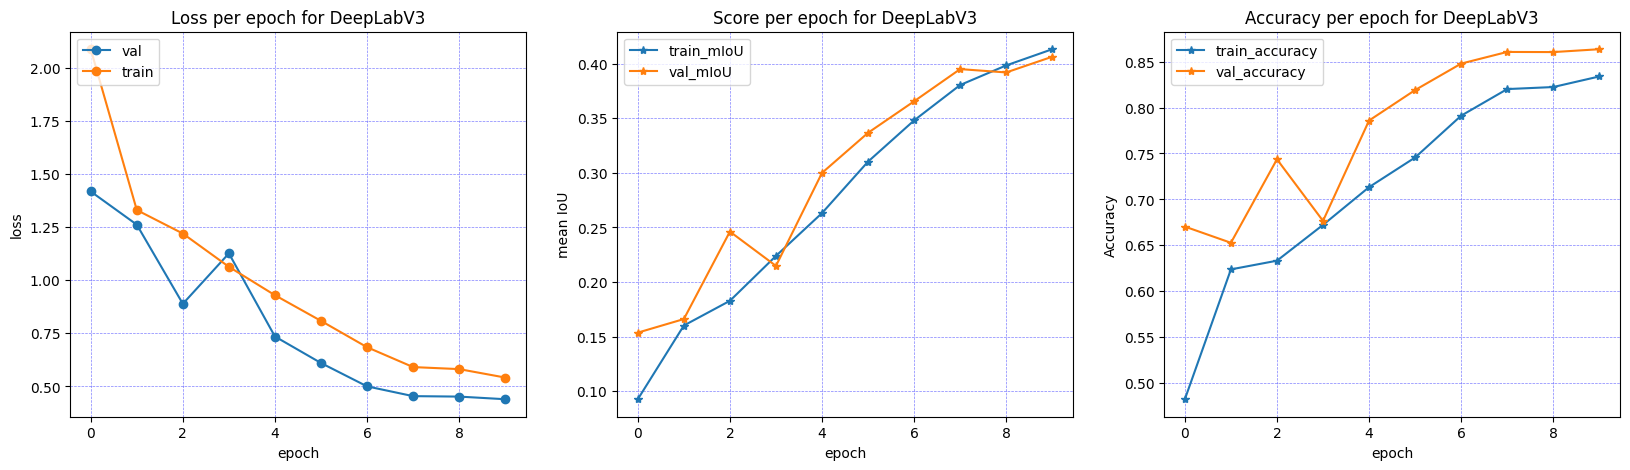

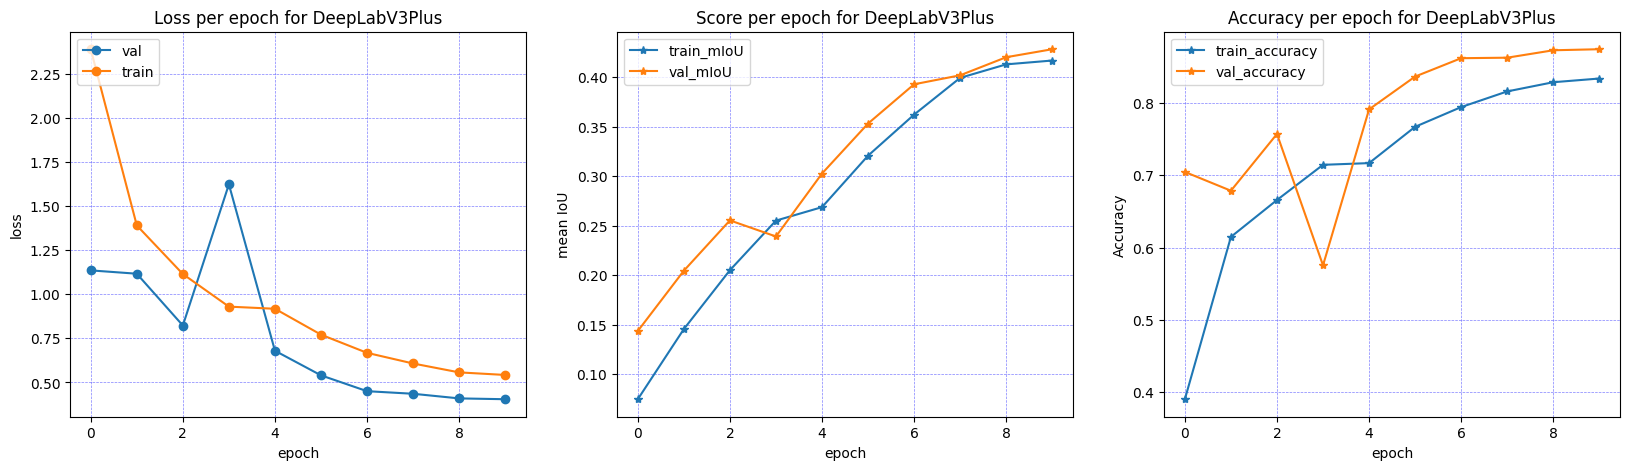

In [36]:
for model_name, history in histories.items():
  plot_loss(history, model_name)

## **Results**

In [37]:
class DroneTestDataset(Dataset):
    def __init__(self, original_images, label_images_semantic, sample, transform=None):
        self.original_images = original_images
        self.label_images_semantic = label_images_semantic
        self.sample = sample
        self.transform = transform
      
    def __len__(self):
        return len(self.sample)
    
    def __getitem__(self, idx):
        image = cv2.cvtColor(cv2.imread(self.original_images + 
                                      self.sample.index.values[idx]), cv2.COLOR_BGR2RGB)
        label = cv2.imread(self.label_images_semantic + self.sample.label_images_semantic.values[idx], cv2.IMREAD_GRAYSCALE)
        if self.transform is not None:
            aug = self.transform(image=image, mask=label)
            image = Image.fromarray(aug['image'])
            label = aug['mask']
        if self.transform is None:
            image = Image.fromarray(image)
        label = torch.from_numpy(label).long()
        
        return image, label

t_test = albumentations.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset('/content/semantic_drone_dataset/original_images/', 
                            '/content/semantic_drone_dataset/label_images_semantic/', x_test, transform=t_test)

In [38]:
def predict_image_label_miou_score_and_accuracy(model, image, label, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize(mean, std)])
    image = transform(image)
    model.to(device); 
    image, label = image.to(device), label.to(device)
    with torch.no_grad():
        image, label = image.unsqueeze(0), label.unsqueeze(0)
        output = model(image)
        score = mIoU(model(image), label)
        accuracy = pixel_accuracy(output, label)
        labeled = torch.argmax(output, dim=1)
        labeled = labeled.cpu().squeeze(0)
    return labeled, score, accuracy

In [39]:
def get_miou_scores(model, test_set):
    miou_scores = list()
    for pair in tqdm(range(len(test_set))):
        image, label = test_set[pair]
        predicted_label, score, accuracy = predict_image_label_miou_score_and_accuracy(model, image, label)
        miou_scores.append(score)
    return miou_scores

def get_pixel_accuracies(model, test_set):
    accuracies = []
    for i in tqdm(range(len(test_set))):
        image, label = test_set[i]
        predicted_label, score, accuracy = predict_image_label_miou_score_and_accuracy(model, image, label)
        accuracies.append(accuracy)
    return accuracies

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

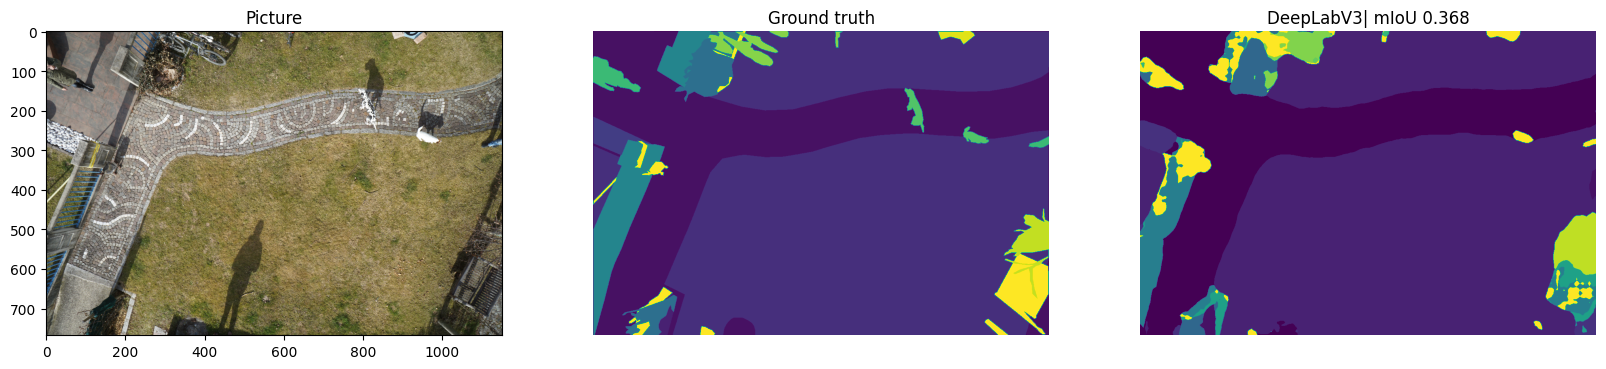

Test Set mIoU for DeepLabV3 : 0.3901514973476803
Test Set Pixel Accuracy for DeepLabV3 : 0.864901026973018


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

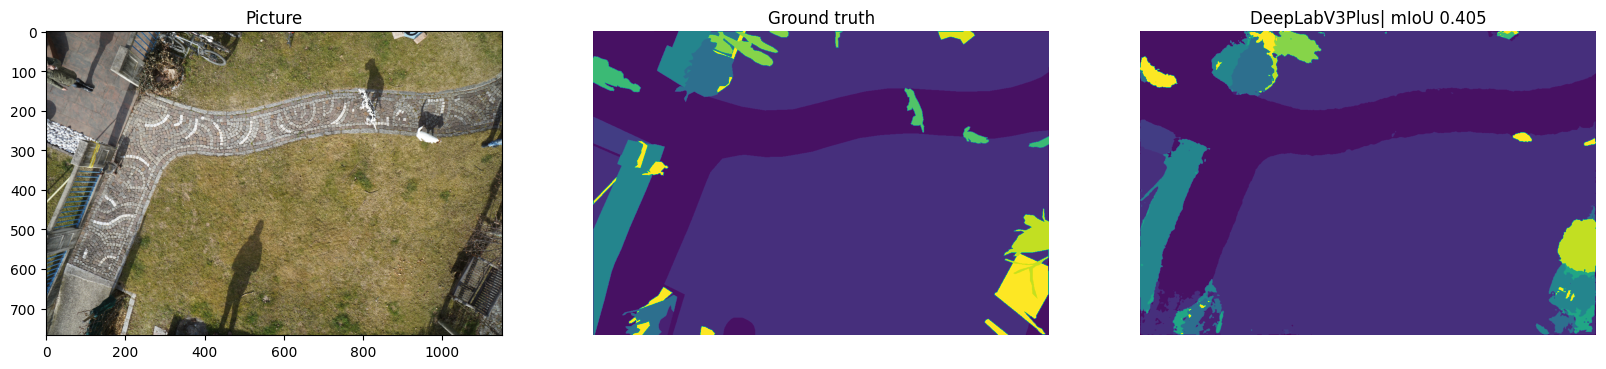

Test Set mIoU for DeepLabV3Plus : 0.39510541512214026
Test Set Pixel Accuracy for DeepLabV3Plus : 0.8676317285608363


In [40]:
for model_name, model in models.items():
  image, label = test_set[3]
  predicted_label, score, accuracy = predict_image_label_miou_score_and_accuracy(model, image, label)
  miou_score = get_miou_scores(model, test_set)
  accuracy = get_pixel_accuracies(model, test_set)

  fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
  ax1.imshow(image)
  ax1.set_title('Picture');
  ax2.imshow(label)
  ax2.set_title('Ground truth')
  ax2.set_axis_off()
  ax3.imshow(predicted_label)
  ax3.set_title(f'{model_name}' +'| mIoU {:.3f}'.format(score))
  ax3.set_axis_off()
  plt.show()

  print(f'Test Set mIoU for {model_name} :', np.mean(miou_score))
  print(f'Test Set Pixel Accuracy for {model_name} :', np.mean(accuracy))